In [1]:
import jax
import jax.numpy as jnp

import mfvi

import jax.scipy.stats as stats
import optax
import seaborn as sns

In [2]:
def loglikelihood_fn(params, batch):
    logpdf = stats.norm.logpdf(batch, params[0], 1)
    return jnp.sum(logpdf)

def prior_fn(params):
    return stats.norm.logpdf(params[0], 10, 2)

def logjoint_fn(params, batch):
    return prior_fn(params) + loglikelihood_fn(params, batch)


def batch_data(rng_key, data, batch_size, data_size):
    """Return an iterator over batches of data."""
    while True:
        _, rng_key = jax.random.split(rng_key)
        idxs = jax.random.choice(
            key=rng_key, a=jnp.arange(data_size), shape=(batch_size,)
        )
        minibatch = jnp.array(tuple(data[idx] for idx in idxs))
        yield minibatch

19662.877
16592.65
13564.23
10503.246
8560.216
7020.1724
6032.3237
4519.6577
3801.6584
3041.2432
2535.1404
2316.7104
1653.6898
1436.9791
1100.5967
1082.3195
849.03467
716.4577
645.3653
488.07727
387.79224
411.95663
340.25607
391.40836
263.70236
239.01743
228.89207
198.4958
219.54823
198.39967
203.93155
194.77312
185.0208
164.13103
174.00116
189.831
156.90817
150.61096
155.42046
173.81714
167.76804
164.9354
164.39679
175.3443
158.90367
162.88809
162.03645
157.03073
159.43925
153.35834
161.34761
160.3855
170.43391
160.7504
160.73445
151.21844
156.67607
155.33022
161.71152
152.92584
153.32492
157.38351
155.69792
155.6937
160.24564
172.40147
152.91295
144.82924
163.25038
149.21353
169.27634
150.62976
155.2345
152.47191
157.5437
153.78085
164.65442
157.47945
160.67259
173.15073
149.57216
145.45393
148.8346
154.93289
151.01564
152.70345
147.71269
152.7642
154.39455
162.25179
154.81958
170.11021
141.55093
165.16243
150.45404
154.54744
163.17456
155.75508
155.32028
153.0573


<Axes: ylabel='Density'>

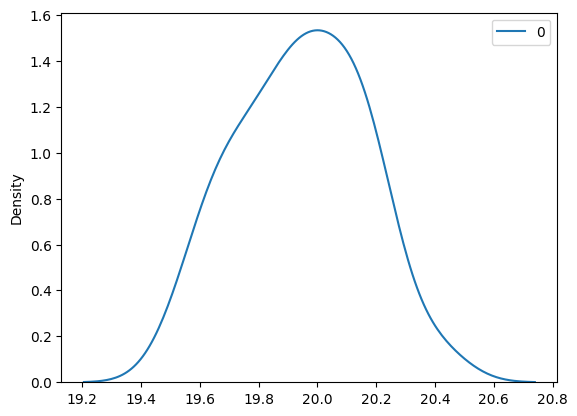

In [3]:
key = jax.random.PRNGKey(123)
optimizer = optax.sgd(1e-3)
pos = jnp.array([1.])
mfvi_state = mfvi.init(pos, optimizer)


num_steps = 100
n_samples = 5
key, subkey = jax.random.split(key)
data = jax.random.normal(jax.random.PRNGKey(1), shape=(500,1)) + 10 * 2
batches = batch_data(subkey, data, 100, 500)

for _ in range(num_steps):

    batch = next(batches)

    mfvi_state, mfvi_info, key = mfvi.step(key, mfvi_state, logjoint_fn, optimizer, batch, n_samples)
    print(mfvi_info.elbo)


meanfield_params = mfvi_state.mu, mfvi_state.rho
posterior_samples, _ = mfvi.meanfield_sample(meanfield_params, key, 50)
sns.kdeplot(posterior_samples)